## **0. Introduction**

This notebook follows after the "General Linear Model.iypnb" notebook. Aim of this notebook is to conduct the support vector machine. For now, we have 26 z-maps, so one for each contrast, for each session, i.e. 4 * 26 z-maps. We will train the SVM on two sessions and then test the SVM on the remaining two sessions.

## **1. Masking**

First we will need to load the mask. The masks needs to be fetched from the openneuro dataset. This is done with *datalad*.

We cd into the local dataset directory and then use the command:

datalad get sourcedata/sub-01/anat.

The masks are bi-lateral organised, meaning one mask per hemisphere. For starters, the higher visual cortex (HVC) will be the first mask.

In [1]:
import os

os.chdir("/home/jpauli/ds001506/sourcedata/sub-01/anat")
os.listdir()

['sub-01_mask_LH_FFA.nii.gz',
 'sub-01_mask_LH_hV4.nii.gz',
 'sub-01_mask_LH_HVC.nii.gz',
 'sub-01_mask_LH_LOC.nii.gz',
 'sub-01_mask_LH_PPA.nii.gz',
 'sub-01_mask_LH_V1d.nii.gz',
 'sub-01_mask_LH_V1v.nii.gz',
 'sub-01_mask_LH_V2d.nii.gz',
 'sub-01_mask_LH_V2v.nii.gz',
 'sub-01_mask_LH_V3d.nii.gz',
 'sub-01_mask_LH_V3v.nii.gz',
 'sub-01_mask_RH_FFA.nii.gz',
 'sub-01_mask_RH_hV4.nii.gz',
 'sub-01_mask_RH_HVC.nii.gz',
 'sub-01_mask_RH_LOC.nii.gz',
 'sub-01_mask_RH_PPA.nii.gz',
 'sub-01_mask_RH_V1d.nii.gz',
 'sub-01_mask_RH_V1v.nii.gz',
 'sub-01_mask_RH_V2d.nii.gz',
 'sub-01_mask_RH_V2v.nii.gz',
 'sub-01_mask_RH_V3d.nii.gz',
 'sub-01_mask_RH_V3v.nii.gz']

In [2]:
len(os.listdir())

22

We can see that there are 22 masks in total, 11 for each hemisphere. 

In [3]:
mask_img_path = '/home/jpauli/ds001506/sourcedata/sub-01/anat'
mask_img_L = os.path.join(mask_img_path,'sub-01_mask_LH_V1v.nii.gz')
mask_img_R = 'sub-01_mask_RH_HVC.nii.gz'

In [76]:
func_filename_path = '/mnt/c/Users/janos/git/sessions_new/z_maps_3'
func_filename =  os.path.join(func_filename_path,'03_active -1443537.0_z_map.nii.gz')
#os.chdir('/mnt/c/Users/janos/git/sessions/z_maps_2')

/home/jpauli/miniconda3/envs/neuro_ai/lib/python3.7/site-packages/numpy/ma/core.py:2830: UserWarning: Warning: converting a masked element to nan.
  order=order, subok=True, ndmin=ndmin)


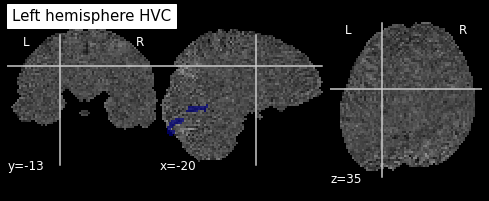

In [77]:
coordinates_func = (-20,-13,35)
from nilearn.plotting import plot_roi
plot_roi(mask_img_L, func_filename,display_mode='ortho',cut_coords=coordinates_func,
         title="Left hemisphere HVC")

Now the next step is to load in the X and Y variables. We will do this by applying Nilearns Niftimasker function on the z_maps we calculated.

In [29]:
from nilearn.maskers import NiftiMasker
nifti_masker = NiftiMasker(mask_img=mask_img_L, standardize=True,
                          smoothing_fwhm=4,
                           memory="nilearn_cache", memory_level=1)

/home/jpauli/miniconda3/envs/neuro_ai/lib/python3.7/site-packages/nilearn/signal.py:68: UserWarning: Standardization of 3D signal has been requested but would lead to zero values. Skipping.
  warnings.warn('Standardization of 3D signal has been requested but '


In [69]:
X = []
Y = []
for session in ["1","2","3","4"]:
    os.chdir('/mnt/c/Users/janos/git/sessions_new/z_maps_{}'.format(session))
    for x in os.listdir():
        if x == 'nilearn_cache':
            continue
        else:
            X.append(nifti_masker.fit_transform(x))
            Y.append(x)
            print(x)
        
        
            
        
        
        



01_active -1443537.0_z_map.nii.gz
01_active -1621127.0_z_map.nii.gz
01_active -1677366.0_z_map.nii.gz
01_active -1846331.0_z_map.nii.gz
01_active -1858441.0_z_map.nii.gz
01_active -1943899.0_z_map.nii.gz
01_active -1976957.0_z_map.nii.gz
01_active -2071294.0_z_map.nii.gz
01_active -2128385.0_z_map.nii.gz
01_active -2139199.0_z_map.nii.gz
01_active -2190790.0_z_map.nii.gz
01_active -2274259.0_z_map.nii.gz
01_active -2416519.0_z_map.nii.gz
01_active -2437136.0_z_map.nii.gz
01_active -2437971.0_z_map.nii.gz
01_active -2690373.0_z_map.nii.gz
01_active -2797295.0_z_map.nii.gz
01_active -2824058.0_z_map.nii.gz
01_active -2882301.0_z_map.nii.gz
01_active -2916179.0_z_map.nii.gz
01_active -2950256.0_z_map.nii.gz
01_active -2951358.0_z_map.nii.gz
01_active -3064758.0_z_map.nii.gz
01_active -3122295.0_z_map.nii.gz
01_active -3124170.0_z_map.nii.gz
01_active -3237416.0_z_map.nii.gz
02_active -1443537.0_z_map.nii.gz
02_active -1621127.0_z_map.nii.gz
02_active -1677366.0_z_map.nii.gz
02_active -184

In [73]:
len(X)

104

In [72]:
len(Y)

104